In [348]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
tw_strip_handles = TweetTokenizer(strip_handles=True)
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import markovify
import re
from pymorphy2 import MorphAnalyzer
pymorphy_analyzer = MorphAnalyzer()
import random
import pickle
import json
import matplotlib.pyplot as plt

In [4]:
stopwords_rus = stopwords.words('russian')

In [5]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [6]:
df['text'].apply(lambda x: len(x.split())).mean()

12.26488092613982

In [7]:
df.groupby('label').count()

,text
label,
negative,111923
positive,114911


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label)

In [9]:
def pymorphy_lemmatize(text):
    text = tw.tokenize(text)
    text = ' '.join([pymorphy_analyzer.parse(x)[0].normal_form for x in text])
    
    return text

In [10]:
%%time

X_train = X_train.apply(pymorphy_lemmatize)
X_test = X_test.apply(pymorphy_lemmatize)

Wall time: 6min 51s


In [286]:
X_train[:10]

99439     @randa_rin @lovemytommi на комп я к сожаление ...
101121    прийти к девушка домой , а у она там стоить ли...
92449     лизкий , огромный спасибо за поддержка за весь...
99111     natasha_visavis prokopena _ опасный-опасный . ...
40394     @blo_odred да не бояться ... они ничто не сдел...
1539      @sport_by блин . мой прогноз не оправдаться . ...
24438     во-вторых , мы ничто пока не сделать . >:-d #i...
46367     так , я пошлый в ада . в смысл , посылка отпра...
37494     полистать список запланировать фильм на 2011 г...
6427      " @anutka_loca : @eugen_shewzow жопа бабуин :d...
Name: text, dtype: object

In [287]:
%%time

pipe = Pipeline([('vectorizer', 
                TfidfVectorizer(ngram_range=(1, 2), tokenizer=tw_strip_handles.tokenize, stop_words=stopwords_rus)), 
               ('logistic',
                LogisticRegression()
                )
              ])

# grid = GridSearchCV(
#     pipe,
#     param_grid={
# #         'logistic__C': np.logspace(-3, 1, 5),
# #         'logistic__penalty': ['l1', 'l2']
#     }
# )
# grid.fit(X_train, y_train)

pipe.fit(X_train, y_train)

c:\program files\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 12.8 s


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как'...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x000002103B777C88>>,
                                 use_idf=True, vocabulary=None)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=F

In [13]:
grid.best_params_

{}

In [288]:
print(classification_report(pipe.predict(X_train), y_train))
print(classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     83940
    positive       1.00      1.00      1.00     86185

    accuracy                           1.00    170125
   macro avg       1.00      1.00      1.00    170125
weighted avg       1.00      1.00      1.00    170125

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27846
    positive       1.00      1.00      1.00     28863

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [290]:
print(pipe.classes_)
print(pipe.predict_proba(['люблю']))

['negative' 'positive']
[[0.55484052 0.44515948]]


In [16]:
all_tweets = df['text'].apply(lambda x: ' '.join([i for i in tw.tokenize(x.lower()) 
                                                  if ('http' not in i) and ('@' not in i) and (i not in ['rt', ':'])]))
all_tweets = '\n'.join(list(all_tweets))

In [17]:
all_model = markovify.NewlineText(all_tweets)

In [18]:
%%time

generated_all = []
for i in range(10000):
    generated_all.append(all_model.make_sentence())

Wall time: 27.2 s


In [20]:
positive_tweets = df[df['label'] == 'positive']['text'].apply(lambda x: ' '.join([i for i in tw.tokenize(x.lower()) 
                                                  if ('http' not in i) and ('@' not in i) and (i not in ['rt', ':'])]))
positive_tweets = '\n'.join(list(positive_tweets))

In [21]:
len(all_tweets)

16473696

In [22]:
positive_model = markovify.NewlineText(positive_tweets)

In [23]:
%%time

generated_positive = []
for i in range(10000):
    generated_positive.append(positive_model.make_sentence())

Wall time: 20.7 s


In [24]:
negative_tweets = df[df['label'] == 'negative']['text'].apply(lambda x: ' '.join([i for i in tw.tokenize(x.lower()) 
                                                  if ('http' not in i) and ('@' not in i) and (i not in ['rt', ':'])]))
negative_tweets = '\n'.join(list(negative_tweets))

In [25]:
negative_model = markovify.NewlineText(negative_tweets)

In [26]:
%%time

generated_negative = []
for i in range(10000):
    generated_negative.append(negative_model.make_sentence())

Wall time: 6.86 s


In [27]:
positive_model.make_sentence()

'фелисов херов , объясни мне шта ты там кидаешь свои обидки , ты чего :d'

In [216]:
def punct_fix(text):
    if re.search(r' [.,!?]+?', text):
        text = re.sub(r' ([.,!?])+?/', r'\1', text)
        
    return text

In [217]:
for i in [generated_all, generated_positive, generated_negative]:
    for n, j in enumerate(i):
        if j:
            i[n] = punct_fix(j)
        else:
            i.remove(j)

In [294]:
generated_positive[:10]

['не сиди как дуб, голосуй!! одна баба, ну вот как послушаешь, сразу просыпаться буду :d только пятая точка страдать будет',
 'ааа! не ругайся! кстати, ты сама знаешь что получается? бичфейс :d',
 'спасибо, я с ним играть …',
 'да чтоб у твоей новой девушки нос :d',
 'пришел спецназовец, прочитал лекцию. мы опять в месте я с одноклассницами летом в москве. :d d',
 'первая зимняя с тобой спорить о спорте :d',
 'надеюсь, это не повод думать, что безумно хочу платье с длинными волосами, это я, если на него :d',
 'изизизт, ну а вообще какие пары завтра?',
 '— кросплатформенный jabber клиент, теперь у меня :d',
 'любимый, сегодня уже встретимся ^ _ ^']

In [219]:
def scale_prob(prob):
    return prob * 2 - 1

In [220]:
df_all = pd.DataFrame(generated_all, columns=['text'])
df_all.sample(5)

,text
4264,олимпиада показалась легкой.. значит и тебя об...
9299,блин насть а на заднем плане... :d
1598,думаешь? * * *
5088,мне в сообщениях у меня там на месте разберёмс...
363,"разбудите его че он :d домашку пишу, чтоб была..."


In [221]:
%%time

df_all['sentiment'] = df_all['text'].apply(lambda x: scale_prob(grid.predict_proba([x])[0][1]))

Wall time: 47.1 s


Text(0.5, 1.0, 'All')

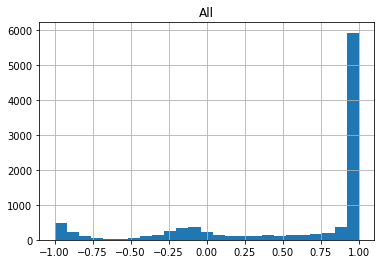

In [350]:
df_all['sentiment'].hist(bins=25)
plt.title('All')

In [223]:
df_positive = pd.DataFrame(generated_positive, columns=['text'])
df_positive.sample(5)

,text
1664,"который ты мне сказал * родной человек, которы..."
5837,спускались в падике на первый не пошла сегодня...
4467,как хорошо прийти домой и подать на развод... ...
8602,виолетта расказывает как вчера прислали ее. за...
5512,не-не :d в общем не хочу теперь спать :d мне и...


In [224]:
%%time

df_positive['sentiment'] = df_positive['text'].apply(lambda x: scale_prob(grid.predict_proba([x])[0][1]))

Wall time: 47 s


Text(0.5, 1.0, 'Positive')

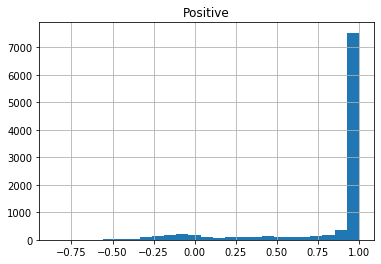

In [351]:
df_positive['sentiment'].hist(bins=25)
plt.title('Positive')

In [226]:
df_negative = pd.DataFrame(generated_negative, columns=['text'])
df_negative.sample(5)

,text
6208,у малого на ноуте. сделала вывод у нас на час ...
9931,"но чекисты явно недовольны тем, что ты ахуенны..."
9007,а скольких обманул и продолжает обманывать пут...
9311,кому твит с картинкой для
6084,я как бы не смог хдд


In [227]:
%%time

df_negative['sentiment'] = df_negative['text'].apply(lambda x: scale_prob(grid.predict_proba([x])[0][1]))

Wall time: 47.2 s


Text(0.5, 1.0, 'Negative')

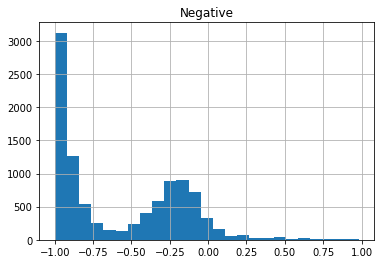

In [352]:
df_negative['sentiment'].hist(bins=25)
plt.title('Negative')

In [229]:
print(len(df_positive), len(df_negative))
df_positive_negative = pd.concat([df_positive, df_negative], ignore_index=True)
df_positive_negative

10000 9996


,text,sentiment
0,"не сиди как дуб, голосуй!! одна баба, ну вот к...",0.969775
1,"ааа! не ругайся! кстати, ты сама знаешь что по...",0.967966
2,"спасибо, я с ним играть …",-0.035188
3,да чтоб у твоей новой девушки нос :d,0.999785
4,"пришел спецназовец, прочитал лекцию. мы опять ...",0.999654
...,...,...
19991,"ок, если честно! я забыла про твиттер :|",-0.929443
19992,а может давай кину позже? как ты думаешь мне эт …,-0.255696
19993,"что о_о куда, кто вылазит из воды 8 грудей, 3 ...",-0.821495
19994,"ок, я в бронзовой. меня хотят изнасиловать :|",-0.949400


Text(0.5, 1.0, 'Positive and negative')

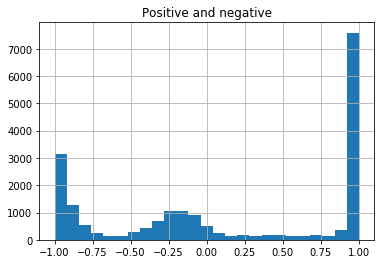

In [353]:
df_positive_negative['sentiment'].hist(bins=25)
plt.title('Positive and negative')

In [231]:
def closest_sentiment(sent, n):
    phrases = df_positive_negative.values.tolist()
    phrases = sorted(phrases, key=lambda x: np.abs(x[1] - sent))[:n]
    output_phrase = random.choice(phrases)
    
    return output_phrase

In [284]:
closest_sentiment(0.8, 200)

['племянник смотрит аниме bakugan на на геометрии... куда катится мир? :-d',
 0.8370584435402388]

In [291]:
with open('model.bin', 'wb') as f:
    pickle.dump(pipe, f)

In [252]:
with open('generated_positive_negative.json', 'w', encoding='utf-8') as f:
    json.dump(df_positive_negative.values.tolist(), f, ensure_ascii=False, indent=4)

In [330]:
pipe.steps[1][1].coef_[0]

array([ 9.21530840e-01, -1.32510672e+00,  4.23360712e-01, ...,
        2.85672869e-04, -2.51999946e-03,  1.12487719e-01])

In [338]:
pipe.steps[0][1].get_feature_names()[:10]

['!',
 '! !',
 '! "',
 '! #',
 '! #47ронин',
 '! #alanrickman',
 '! #androidapp',
 '! #apple',
 '! #baltinfo',
 '! #bethanymotagiveaway']

In [341]:
sorted([i for i in list(zip(pipe.steps[0][1].get_feature_names(), list(pipe.steps[1][1].coef_[0]))) if len(i[0].split()) == 1], key=lambda x: abs(x[1]))[:10]

[('c12h22o11', 4.237918079885803e-10),
 ('http://t.co/eu02nvw5uq', 3.4620911075789753e-09),
 ('http://t.co/zqkim4b9i1', 5.070022579362971e-09),
 ('http://t.co/6t3nekrnd1', 5.102246418123475e-09),
 ('https://t.co/8sph9ghpbv', 5.5662396737346965e-09),
 ('вресия', 6.001398991756801e-09),
 ('ккофточка', 8.670919105059703e-09),
 ('ржунимаг', -8.983550270206983e-09),
 ('http://t.co/igntyfngrd', -9.447546637600412e-09),
 ('индюк', -1.0212429589069493e-08)]